# PPO

---

In [16]:
import os, sys, random

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

import imageio
from IPython.display import Image

In [ ]:
# Global variables

SEED = 42

OUT_DIR_PPO = './outputs_PPO/'
os.makedirs(OUT_DIR_PPO, exist_ok=True)

TENSORBOARD_LOGS_DIR = OUT_DIR_PPO + "tensorboard/"
SAVE_MODEL_PATH = OUT_DIR_PPO + "model_ppo.zip"

MODEL_NAME = "LunarLander-v3"
MLP_POLICY = "MlpPolicy"

WIND_ENABLED = True

In [ ]:
random.seed(SEED)

# Assure reproducibility on numpy:
# Affects functions like np.random.rand, np.random.shuffle, etc.
np.random.seed(SEED)

# Assure reproducibility on Torch:
# Affects weight initialization, dropout, data shuffling, etc.
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
print("Base output directory:", OUT_DIR_PPO)
print("TensorBoard logs directory:", TENSORBOARD_LOGS_DIR)
print("PPO model save path:", SAVE_MODEL_PATH)

env = gym.make(MODEL_NAME)
env.reset(seed=SEED)

# Select device: use GPU if available, otherwise fallback to CPU
# This will be very important do control in which device the processing will happen
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("Device:", DEVICE)
print("CUDA:", torch.version.cuda if torch.cuda.is_available() else "None")

Base output directory: ./outputs_PPO/
TensorBoard logs directory: ./outputs_PPO/tensorboard/
PPO model save path: ./outputs_PPO/model_ppo.zip
Python: 3.12.3
PyTorch: 2.10.0+cu130
Device: cpu
CUDA: 13.0


In [4]:
# Create a temporary environment instance (for inspection only, not for training)
env_tmp = gym.make(MODEL_NAME)

# Print the observation space: min/max values for position and velocity
print("Observation space:", env_tmp.observation_space)
# Print the action space: valid range of the continuous acceleration input
print("Action space:", env_tmp.action_space)

# Reset the environment and display the initial state (position and velocity)
obs, info = env_tmp.reset()
print("Initial observation:", obs)

env_tmp.close()

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Initial observation: [ 0.00783339  1.4101534   0.79340726 -0.03410006 -0.00907    -0.17971855
  0.          0.        ]


In [ ]:
def make_env_lunarlander():
    
    # It is a good practice to set the seed inside the factory if not using VecEnv.seed()
    env = gym.make(MODEL_NAME,
                   render_mode="rgb_array",
                   enable_wind=WIND_ENABLED)
    
    # Redundant if env_mc.seed(SEED) is used
    env.reset(seed=SEED)
    return env

env_mc = DummyVecEnv([make_env_lunarlander])
env_mc.seed(SEED)

In [ ]:
model_ppo = PPO(
    policy=MLP_POLICY,
    env=env_mc,
    learning_rate=2.5e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.999,
    gae_lambda=0.95,
    ent_coef=0.01,
    clip_range=0.2,
    device=DEVICE,

    # verbose 0 for disable logs and 1 for enable
    verbose=0,
    seed=SEED,
    tensorboard_log=TENSORBOARD_LOGS_DIR,
)

In [7]:
# def make_silent_logger(log_dir):
#     """
#     Create a logger that writes logs to TensorBoard but does NOT print anything to stdout.
#     """
#     return configure(
#         log_dir,
#         format_strings=["tensorboard"]
#     )

# silent_logger = make_silent_logger(TENSORBOARD_LOGS_DIR)

# Attach silent logger
#model_ppo.set_logger(silent_logger)

In [8]:
class PPOLoggingCallback(BaseCallback):
    """
    Custom callback to track key PPO training metrics:
    Episode-level:
        - episode_rewards : Total reward per episode
        - episode_lengths : Number of steps per episode

    Update-level (logged by PPO internally):
        - policy_loss    : How much the policy is being updated
        - value_loss     : Error of the critic value function
        - entropy        : Measures exploration vs determinism

    """

    def __init__(self, verbose=0):
        super().__init__(verbose)
        # These lists will store the metrics we want to analyse after training.
        self.episode_rewards = []     # Total reward for each completed episode
        self.episode_lengths = []     # Number of timesteps per episode

        # Temporary accumulators for rewards & episode lengths
        self._current_rewards = None
        self._current_lengths = None

        # PPO internal training metrics (per rollout)
        self.policy_loss = []
        self.value_loss = []
        self.entropy = []

    def _on_training_start(self):
      """Called once at the beginning of training."""

      # Determine how many parallel environments exist (VecEnv).
      # This matters only if we use multiple envs; with a single env, as our example, n_envs = 1
      n_envs = self.training_env.num_envs  # Number of parallel environments (usually 1 in this notebook)

      # Each environment needs its own reward and length accumulator.
      self._current_rewards = np.zeros(n_envs, dtype=np.float32)
      self._current_lengths = np.zeros(n_envs, dtype=np.int32)

    def _on_step(self):
        """Called at every environment step."""

        rewards = self.locals["rewards"] # rewards for each parallel env
        dones = self.locals["dones"] # done flags for each parallel env

        # Accumulate reward for each running episode
        self._current_rewards += rewards

        # Count steps for each environment
        self._current_lengths += 1

        # If an episode ended in any env, store its results
        for i, done in enumerate(dones):
            if done:
                # Store completed episode metrics
                self.episode_rewards.append(self._current_rewards[i])
                self.episode_lengths.append(self._current_lengths[i])

                # Reset accumulators for that env to start a new episode
                self._current_rewards[i] = 0.0
                self._current_lengths[i] = 0

        return True

    def _on_rollout_end(self):
        """
        Called at the end of each PPO rollout (i.e., before policy update).
        PPO logs its own metrics inside self.model.logger.
        We extract the latest values here.
        """
        logger_data = self.model.logger.name_to_value

        # Policy loss → measures strength of policy update
        if "train/policy_loss" in logger_data:
            self.policy_loss.append(logger_data["train/policy_loss"])

        # Value loss → critic learning stability
        if "train/value_loss" in logger_data:
            self.value_loss.append(logger_data["train/value_loss"])

        # Entropy loss is negative → invert sign to get entropy magnitude
        if "train/entropy_loss" in logger_data:
            self.entropy.append(-logger_data["train/entropy_loss"])

        return True


In [9]:
callback_ppo = PPOLoggingCallback()

# In standard PPO training, the total number of timesteps is often much higher (hundreds of thousands or even millions). However, with the tailored
# hyperparameter configuration we are using here, and given that our goal is purely educational, we can train for a much smaller number of steps while
# still obtaining meaningful results.
total_timesteps_ppo = 750_000

model_ppo.learn(
    total_timesteps=total_timesteps_ppo,
    callback=callback_ppo,
    progress_bar=True,
)

print("Number of episodes recorded:", len(callback_ppo.episode_rewards))

Output()

Number of episodes recorded: 1965


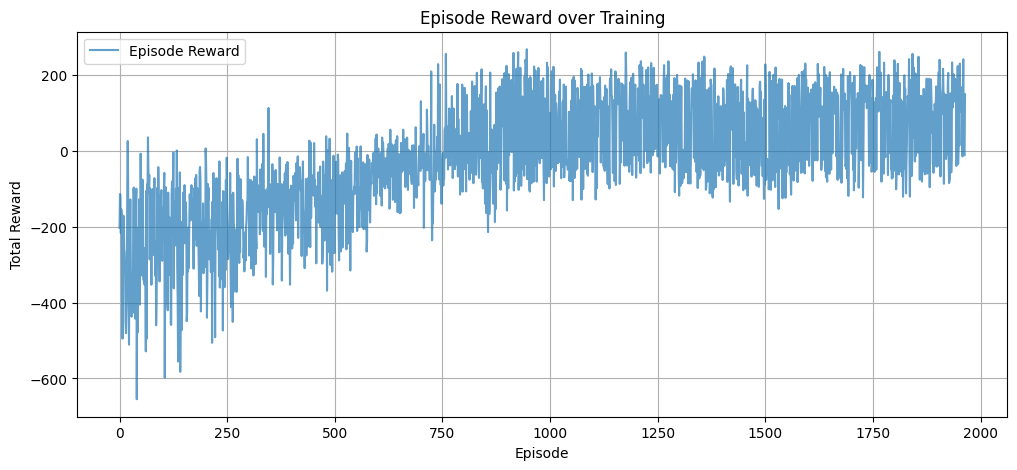

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(callback_ppo.episode_rewards, label="Episode Reward", alpha=0.7)
plt.title("Episode Reward over Training")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.show()

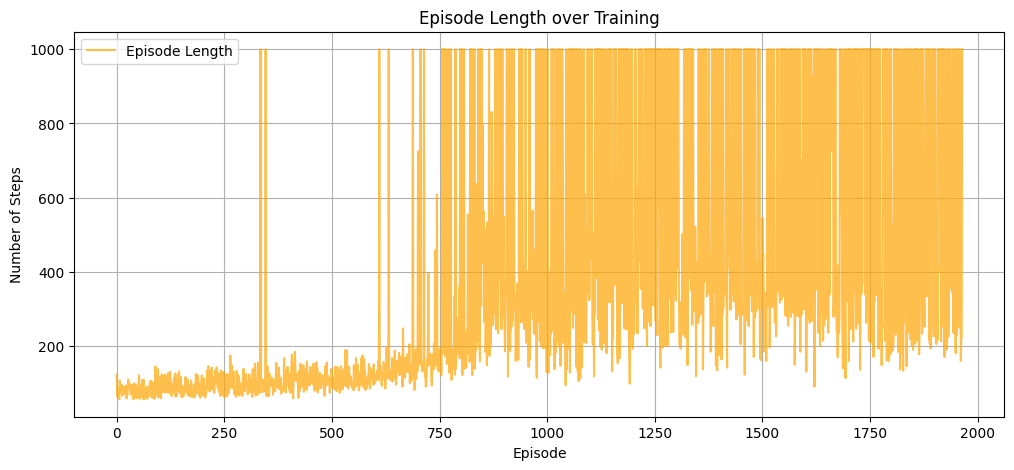

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(callback_ppo.episode_lengths, label="Episode Length", alpha=0.7, color="orange")
plt.title("Episode Length over Training")
plt.xlabel("Episode")
plt.ylabel("Number of Steps")
plt.grid(True)
plt.legend()
plt.show()

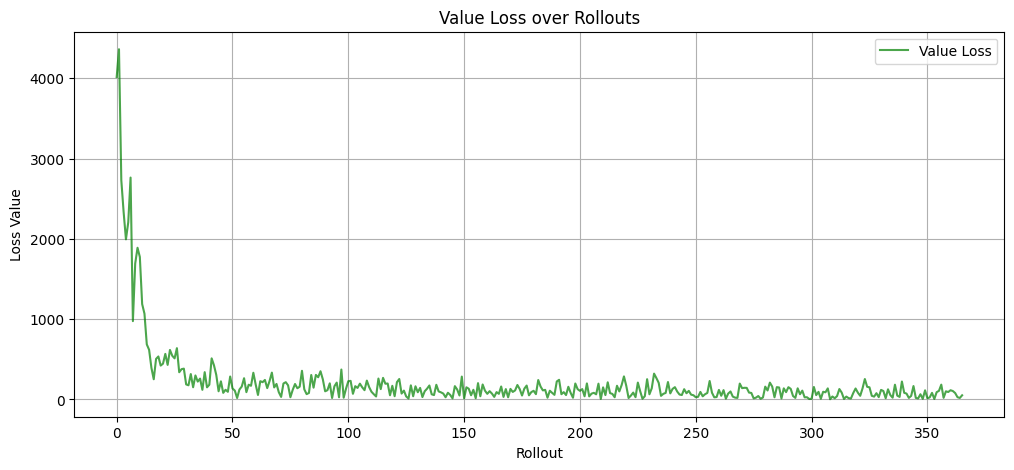

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(callback_ppo.value_loss, label="Value Loss", alpha=0.7, color="green")
plt.title("Value Loss over Rollouts")
plt.xlabel("Rollout")
plt.ylabel("Loss Value")
plt.grid(True)
plt.legend()
plt.show()


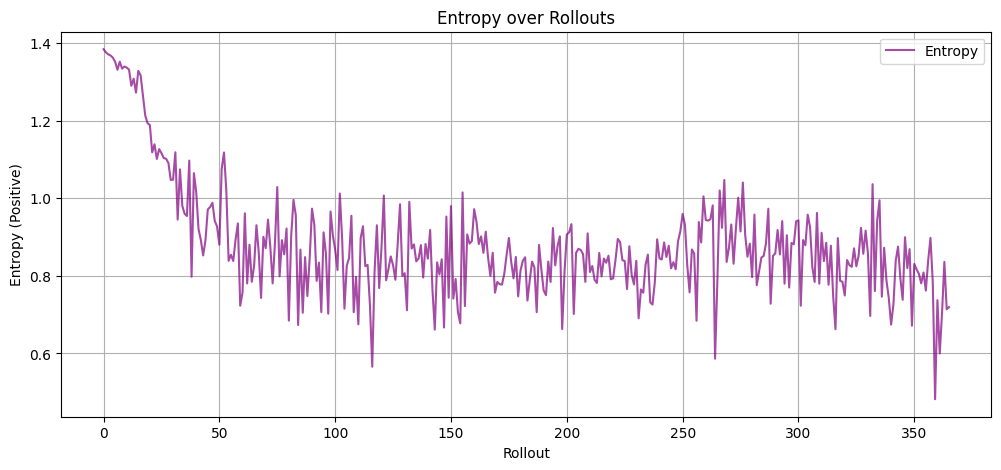

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(callback_ppo.entropy, label="Entropy", alpha=0.7, color="purple")
plt.title("Entropy over Rollouts")
plt.xlabel("Rollout")
plt.ylabel("Entropy (Positive)")
plt.grid(True)
plt.legend()
plt.show()


In [14]:
# Create new, clean environment
eval_env_mc = Monitor(gym.make(MODEL_NAME))

# Get raw rewards per episode
episode_rewards, _ = evaluate_policy(
    model_ppo,
    eval_env_mc,
    n_eval_episodes=100,
    deterministic=True,
    return_episode_rewards=True
)

# Compute statistics
mean_reward = np.mean(episode_rewards)
std_reward = np.std(episode_rewards)
min_reward = np.min(episode_rewards)
max_reward = np.max(episode_rewards)

# Print results
print(f"PPO Evaluation on " + MODEL_NAME)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")
print(f"Min reward: {min_reward:.2f}")
print(f"Max reward: {max_reward:.2f}")

eval_env_mc.close()

PPO Evaluation on LunarLander-v3
Mean reward: 232.58 ± 48.79
Min reward: 24.28
Max reward: 297.71


🚀 Starting Stress Test: 500 episodes...

--- PPO EVALUATION SUMMARY (500 EPISODES) ---
                    Metric  Value
               Mean Reward 230.75
        Standard Deviation  52.29
            Minimum Reward -20.63
            Maximum Reward 292.29
Success Rate (Score > 200)  83.6%


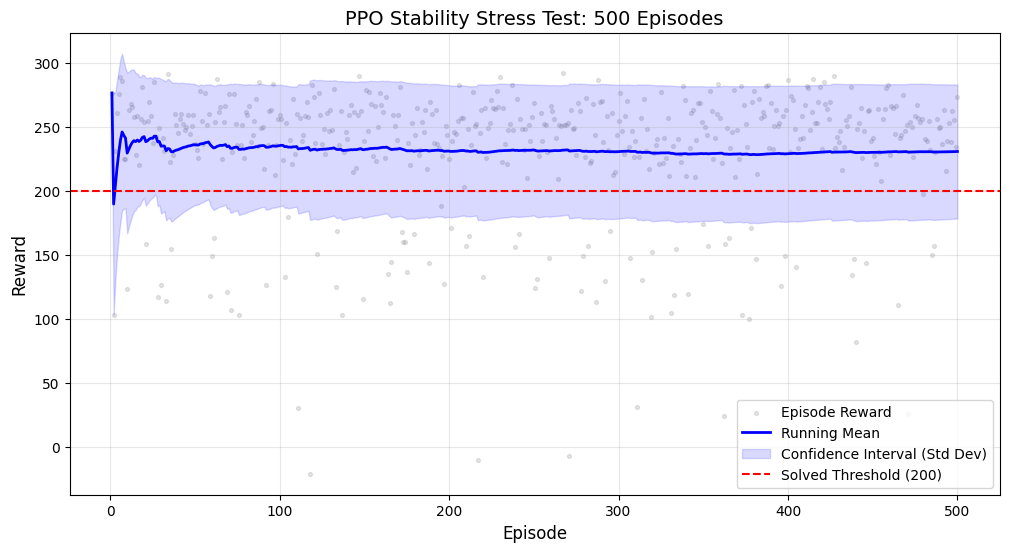

In [17]:
# 1. Setup Environment
eval_env_mc = Monitor(gym.make(MODEL_NAME))

# 2. Dynamic Evaluation for 500 Episodes
NUM_EPISODES = 500
print(f"🚀 Starting Stress Test: {NUM_EPISODES} episodes...")

episode_rewards, _ = evaluate_policy(
    model_ppo,
    eval_env_mc,
    n_eval_episodes=NUM_EPISODES,
    deterministic=True,
    return_episode_rewards=True
)

# 3. Compute Final Statistics
rewards = np.array(episode_rewards)
stats = {
    "Metric": ["Mean Reward", "Standard Deviation", "Minimum Reward", "Maximum Reward", "Success Rate (Score > 200)"],
    "Value": [
        f"{np.mean(rewards):.2f}",
        f"{np.std(rewards):.2f}",
        f"{np.min(rewards):.2f}",
        f"{np.max(rewards):.2f}",
        f"{(rewards >= 200).sum() / NUM_EPISODES * 100:.1f}%"
    ]
}

# Display Summary Table
df_stats = pd.DataFrame(stats)
print("\n--- PPO EVALUATION SUMMARY (500 EPISODES) ---")
print(df_stats.to_string(index=False))

# 4. Generate the 500-episode Convergence Plot
episodes = np.arange(1, len(rewards) + 1)
running_mean = np.cumsum(rewards) / episodes
running_std = np.array([np.std(rewards[:i]) for i in episodes])

plt.figure(figsize=(12, 6))
plt.scatter(episodes, rewards, color='gray', alpha=0.2, s=8, label='Episode Reward')
plt.plot(episodes, running_mean, color='blue', linewidth=2, label='Running Mean')
plt.fill_between(episodes, running_mean - running_std, running_mean + running_std, color='blue', alpha=0.15, label='Confidence Interval (Std Dev)')
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')

plt.title(f'PPO Stability Stress Test: {NUM_EPISODES} Episodes', fontsize=14)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

eval_env_mc.close()

In [18]:
# Create the environment WITH wind
env_wind = Monitor(gym.make(MODEL_NAME, enable_wind=True))

# Test your existing PPO model on this new environment
rewards_wind, _ = evaluate_policy(
    model_ppo, 
    env_wind, 
    n_eval_episodes=100, 
    deterministic=True, 
    return_episode_rewards=True
)

print(f"PPO Performance with Wind (Zero-Shot): {np.mean(rewards_wind):.2f} ± {np.std(rewards_wind):.2f}")

PPO Performance with Wind (Zero-Shot): 147.15 ± 100.72


In [ ]:
# Create a visual environment for recording
vis_env = gym.make(MODEL_NAME, render_mode="rgb_array")

frames = []
obs, info = vis_env.reset()
done = False

while not done:
    # PPO outputs a continuous action
    action, _ = model_ppo.predict(obs, deterministic=True)

    obs, reward, terminated, truncated, info = vis_env.step(action)
    done = terminated or truncated

    # Capture frame
    frames.append(vis_env.render())

vis_env.close()


gif_path = os.path.join(OUT_DIR_PPO, "ppo_lunarlander.gif")
# Save GIF at 30 frames per second
imageio.mimsave(gif_path, frames, fps=30)

print(f"Saved visualization to: {gif_path}")
Image(filename=gif_path)

In [ ]:
#%load_ext tensorboard
#%reload_ext tensorboard
#%tensorboard --logdir $TENSORBOARD_LOGS_DIR

In [ ]:
print(f"Saving model to: {SAVE_MODEL_PATH}")
model_ppo.save(SAVE_MODEL_PATH)

In [ ]:
print("Loading the saved model...")
env2 = DummyVecEnv([make_env])
loaded_model = DQN.load(SAVE_MODEL_PATH, env=env2)

In [ ]:
obs = env2.reset()
done = False
total_reward = 0

while not done:
    action, _ = loaded_model.predict(obs, deterministic=True)
    obs, reward, done, info = env2.step(action)
    total_reward += reward

print(f"Total reward by the loaded model: {total_reward}")